# Bandits

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from mclearn.active import ActiveBandit
from mclearn.heuristics import random_h, entropy_h, margin_h, qbb_kl_h, qbb_margin_h
from mclearn.tools import results_exist, load_results
from mclearn.preprocessing import balanced_train_test_split
from mclearn.viz import (plot_average_learning_curve, plot_heuristic_selections,
                         plot_bandit_parameters)
%matplotlib inline
plt.style.use('ggplot')

## Preparing the VST ATLAS Dataset

In [3]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
fig_dir = '../thesis/figures/'
target_col = 'class'
feature_cols = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [4]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='ovr', penalty='l1', C=100,
                                         random_state=2, class_weight='auto')
committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1,
                              max_samples=300)
# list of all heuristics to be used (and the paths where results are saved)
heuristics = [random_h, entropy_h, margin_h, qbb_kl_h, qbb_margin_h]
labels = ['Random', 'Entropy', 'Margin', 'QBB KL', 'QBB Margin']

# class names need to be sorted alphabetically
classes = ['Galaxy', 'Quasar', 'Star', 'White Dwarf']

scaler = StandardScaler()
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

X_scaled = scaler.fit_transform(vstatlas[feature_cols])
X_poly = transformer.fit_transform(X_scaled)
y = np.array(vstatlas[target_col])

# balance the training set
X_poly, _, y, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0)

kfold = StratifiedShuffleSplit(y, n_iter=20, test_size=0.3, train_size=0.7,
                               random_state=19)

## Bandit Experiment

In [5]:
def run_bandit_expt(pickle_paths):
    learning_curves = []
    heuristic_selections = []
    mus = []
    sigmas = []

    for i, (train_index, test_index) in enumerate(kfold):
        X_train = X_poly[train_index]
        X_test = X_poly[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        active_bandits = ActiveBandit(classifier=logistic_classifier,
                                       heuristics=heuristics,
                                       initial_n=20,
                                       training_size=400,
                                       sample_size=len(y_train),
                                       committee=committee,
                                       verbose=True)

        active_bandits.fit(X_train, y_train, X_test, y_test)
        learning_curves.append(active_bandits.learning_curve_)
        heuristic_selections.append(active_bandits.heuristic_selection)
        mus.append(active_bandits.all_prior_mus)
        sigmas.append(active_bandits.all_prior_sigmas)

        print(i, end='')

    outputs = [learning_curves, heuristic_selections, mus, sigmas]
    for pickle_path, output in zip(pickle_paths, outputs):
        with open(pickle_path, 'wb') as f:
            pickle.dump(output, f, protocol=4)

In [6]:
pickle_paths = ['../pickle/08_bandits/bandits_learning_curves.pickle',
                '../pickle/08_bandits/bandits_heuristic_selections.pickle',
                '../pickle/08_bandits/bandits_mus.pickle',
                '../pickle/08_bandits/bandits_sigmas.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(pickle_paths)

learning_curves, heuristic_selections, mus, sigmas = load_results(pickle_paths)

....0....1....2....3....4....5....6....7....8....9....10....11....12....13....14....15....16....17....18....19

## Results

This is the average learning curve from 20 trials.

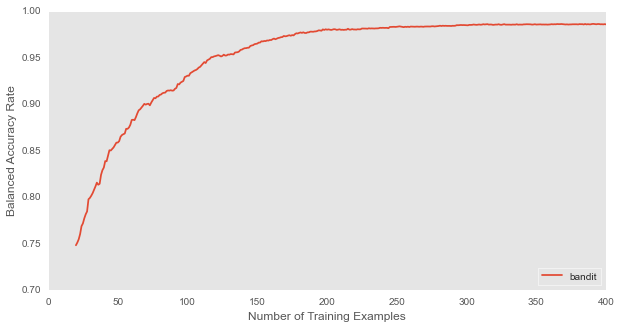

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plot_average_learning_curve(np.arange(20, 401), [learning_curves], ['bandit'])

Here is the cumulative plot of the number of times each heuristic is selected. To examine individual trials, slice `heuristic_selections`, for example `heuristic_selections[0:1]` will give us the results from trial 1.

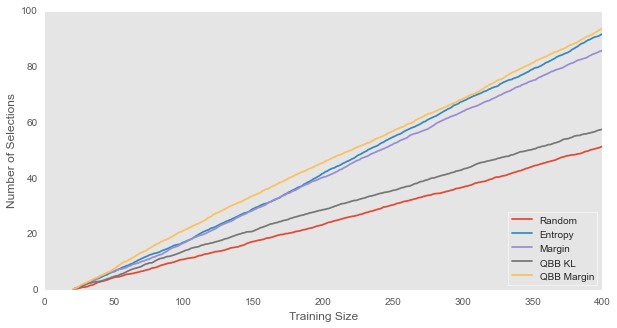

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = plot_heuristic_selections(np.arange(21, 401), heuristic_selections, labels)

How the prior mean of the reward distribution changes over time. Here we assume the reward follows a Gaussian distribution.

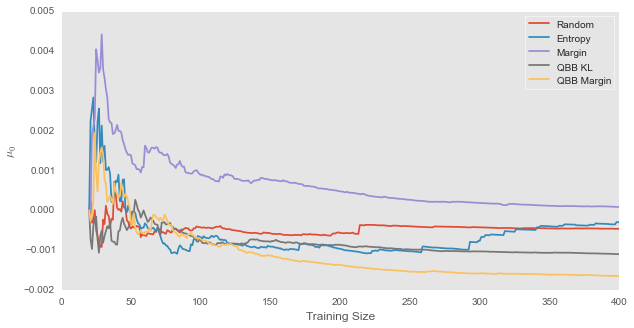

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = plot_bandit_parameters(np.arange(20, 401), mus, labels, ylabel='$\mu_0$')

How the prior variance of the reward distribution changes over time.

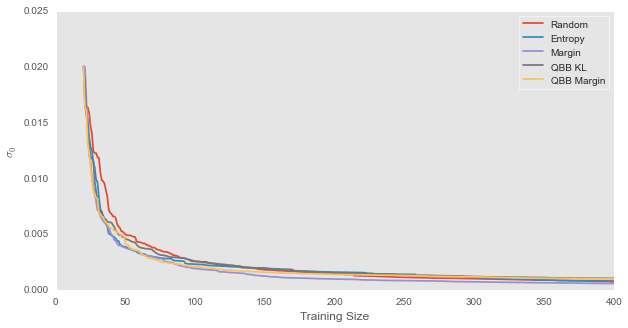

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = plot_bandit_parameters(np.arange(20, 401), sigmas, labels, ylabel='$\sigma_0$')